# Binning Sources in an `Ensemble`

In this notebook we build upon the concepts introduced in the "Working with the lsstseries Ensemble" notebook to focus on internal helper functions for binning light curves.

We reuse the example set of lightcurves from the previous notebook:

In [1]:
from lsstseries.ensemble import Ensemble
import matplotlib.pyplot as plt

ens = Ensemble()  # initialize an ensemble object

# Read in data from a parquet file
ens.from_parquet(
    "../../tests/lsstseries_tests/data/test_subset.parquet",
    id_col="ps1_objid",
    time_col="midPointTai",
    flux_col="psFlux",
    err_col="psFluxErr",
    band_col="filterName",
)

As in the last notebook tutorial, we now have an `Ensemble` object filled with data from a parquet file.

## Binning Sources

Depending on the data set that we use, our light curves could contain a large number of closely spaced observations. For example, we can see a histogram of the observations from the example parquet file.

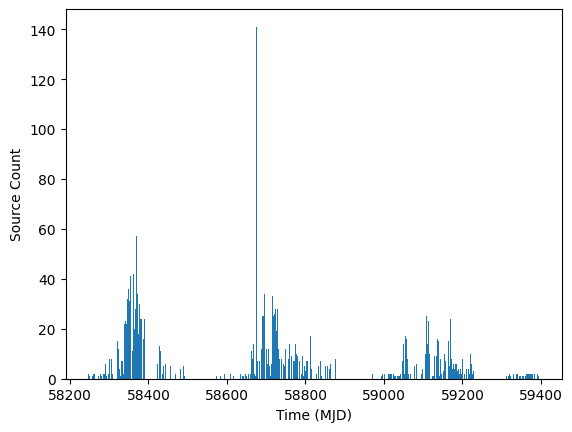

In [2]:
fig, ax = plt.subplots(1, 1)
_ = ax.hist(ens._source["midPointTai"].compute().tolist(), 500)
_ = ax.set_xlabel("Time (MJD)")
_ = ax.set_ylabel("Source Count")

## Binning Sources

The `Ensemble` object provides the function `bin_sources()` to compress multiple sources down to a single observation. This can be useful for either a) reducing the noise in our source estimate by combining multiple sources, or b) reducing the amount of memory used to store sources. **Note**: Only slow changing sources should be combined so as not to lose valuable information about the changes themselves.

The `bin_sources()` function uses floating-point truncation on the timestamp to produce the bins.  Specifically for a given timestamp `t`, window `time_window`, and `offset`, the bin is computed as:

`b = np.floor((t + offset) / time_window) * time_window`

The `time_window` parameter is specified in days and indicates how large the bins are. The `offset` parameter allows the user to indicate where the division between different nights/observing blocks should be. This should correspond to the time stamp's fractional part during the middle of the daylight hours.

Below we use bin the results into one week buckets (`time_window=7.0`) and use `offset=0.0`.

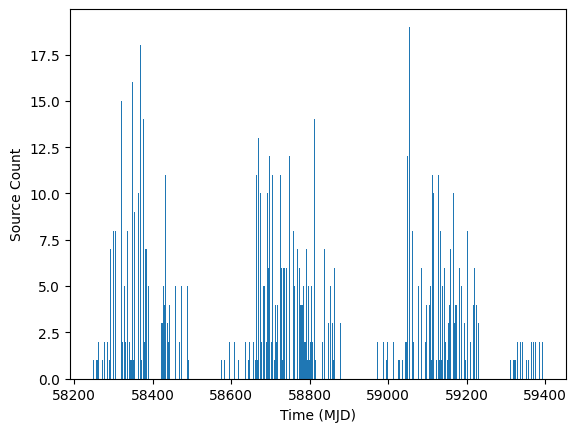

In [3]:
ens.bin_sources(time_window=7.0, offset=0.0)
fig, ax = plt.subplots(1, 1)
_ = ax.hist(ens._source["midPointTai"].compute().tolist(), 500)
_ = ax.set_xlabel("Time (MJD)")
_ = ax.set_ylabel("Source Count")

By default `bin_sources` only preserves the id, band, timestamp, flux, and flux error columns. Timestamps and fluxes within a bin are computed as a simple (unweighted) *mean* value within the bin. The Flux error is computed by taking the `N` error estimates in the bin `[e_0, e_1, ... e_(N-1)]` as:

`flux_error = np.sqrt(sum_i (e_i * e_i)) / N`

We can include additional columns or use different aggregation functions by specifying them in the `custom_aggr` parameter. For example, if we want to use the minimum timestamp within a bin, we could set:

```
custom_aggr={'midPointTai':'min'}
```

**Note:** Using the custom aggregations will produce a warning if we overwrite the aggregation function for one of the main columns, such as `midPointTai` in this example.

/home/jeremykubica/ls_clean/lsstseries/src/lsstseries/ensemble.py:422: UserWarning: Warning: Overwriting aggregation function for column midPointTai.
  warnings.warn(f"Warning: Overwriting aggregation function for column {key}.")


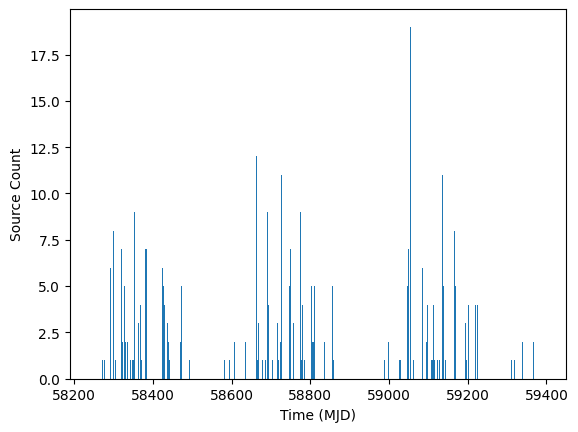

In [4]:
ens.bin_sources(time_window=28.0, offset=0.0, custom_aggr={"midPointTai": "min"})
fig, ax = plt.subplots(1, 1)
_ = ax.hist(ens._source["midPointTai"].compute().tolist(), 500)
_ = ax.set_xlabel("Time (MJD)")
_ = ax.set_ylabel("Source Count")

## Determining Offsets

If we choose the wrong offset, we can end up splitting data from the same night while also splitting data from the same night. Consider the dataset below which represents two nights of observing where the fractional time 0.0 corresponds to midnight at the observatory. In this case timestamps 4.9 and 5.1 would represent observations on the same night.

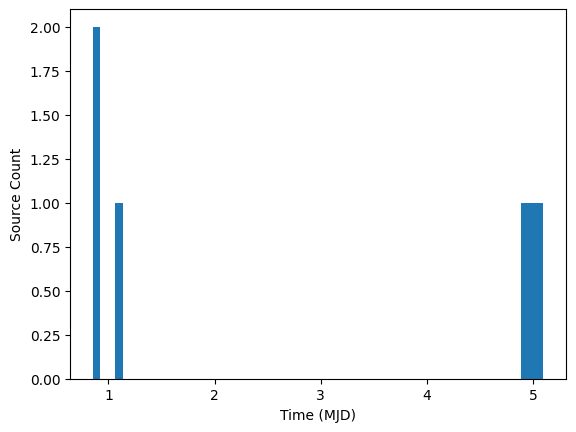

In [5]:
rows = {
    ens._id_col: [1, 1, 1, 1, 1, 1],
    ens._time_col: [0.85, 0.9, 1.1, 4.9, 5.0, 5.1],
    ens._flux_col: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    ens._band_col: ["g", "g", "g", "g", "g", "g"],
}
ens.from_source_dict(rows)

fig, ax = plt.subplots(1, 1)
_ = ax.hist(ens._source["midPointTai"].compute().tolist(), 60)
_ = ax.set_xlabel("Time (MJD)")
_ = ax.set_ylabel("Source Count")

If we bin with `offset=0.0`, we round each timestamp down to the nearest integer. This splits the observations within a night. The observation at time 4.9 is binned at 4.0 and the observation at 5.1 is binned at 5.0.

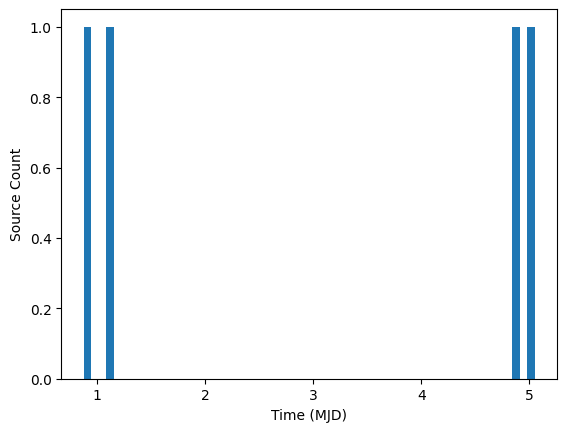

In [6]:
rows = {
    ens._id_col: [1, 1, 1, 1, 1, 1],
    ens._time_col: [0.85, 0.9, 1.1, 4.9, 5.0, 5.1],
    ens._flux_col: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    ens._band_col: ["g", "g", "g", "g", "g", "g"],
}
ens.from_source_dict(rows)
ens.bin_sources(time_window=1.0, offset=0.0)

fig, ax = plt.subplots(1, 1)
_ = ax.hist(ens._source["midPointTai"].compute().tolist(), 60)
_ = ax.set_xlabel("Time (MJD)")
_ = ax.set_ylabel("Source Count")

In contrast, if we bin at 0.5 (the middle of the day for this data), the observations on the same night are correctly associated.

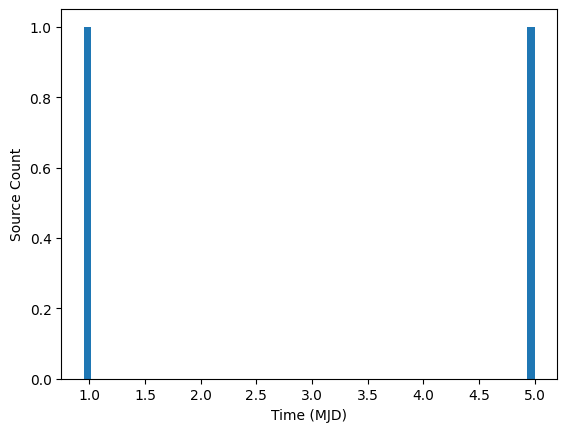

In [7]:
# Reset the data.
rows = {
    ens._id_col: [1, 1, 1, 1, 1, 1],
    ens._time_col: [0.85, 0.9, 1.1, 4.9, 5.0, 5.1],
    ens._flux_col: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    ens._band_col: ["g", "g", "g", "g", "g", "g"],
}
ens.from_source_dict(rows)
ens.bin_sources(time_window=1.0, offset=0.5)

fig, ax = plt.subplots(1, 1)
_ = ax.hist(ens._source["midPointTai"].compute().tolist(), 60)
_ = ax.set_xlabel("Time (MJD)")
_ = ax.set_ylabel("Source Count")

The optimal offset is the middle of the daylight hours for the timezone where the observatory is located. Ideally we compute this directly from our knowledge of the observatory's longitude.

We also provide a helper function that tries to estimate this offset from the data. `find_day_gap_offset()` computes a histogram of the number of observations in each hour (24 bins). It aggregates these counts over all days, so telescope downtime on one night (due to maintenance or weather) would be offset by observations from another night. A bin will only end up with zero if the data never contains a source during this hour of the day. 

The code looks for the longest stretch of bins with zero counts. It returns the middle timestamp of this stretch as the proposed offset.

There are a few important notes when using `find_day_gap_offset`:
* The function uses a Dask `compute()` to materialize the histogram and thus does not use lazy evaluation. As discussed in the other notebooks, one of the advantages of Dask is that it uses lazy evaluation to hold off computations until they are needed, allowing the work to be batched. Because we need to access values in the histogram, this function forces the computation.
* The function is designed for observatories in a single (or small range of) timezones. If the data combines observations throughout the entire 24 hour window, there is not “day time” to use.

In [8]:
# Reload the data from the parquet file (to undo the previous binning)
ens.from_parquet(
    "../../tests/lsstseries_tests/data/test_subset.parquet",
    id_col="ps1_objid",
    time_col="midPointTai",
    flux_col="psFlux",
    err_col="psFluxErr",
    band_col="filterName",
)

print(f"Suggested offset is {ens.find_day_gap_offset()}")

Suggested offset is 0.7916666666666666


In [9]:
ens.client.close()  # Tear down the ensemble client